## Final Project: BloodMNIST CNN Classification

### Goal:

To build a convolutional neural network (CNN) to classify images of blood cells into 8 types using the BloodMNIST dataset. 

#### Process:
- Load, visualize, and preprocess the dataset (https://medmnist.com/)

- Build a CNN in TensorFlow/Keras

- Train and evaluate

- Report performance (accuracy, AUC, F1-score)

- Visualize predictions and confusion matrix

- Markdown documentation

### Step 1: Download dataset and preprocessing

In [2]:
#%pip install medmnist tensorflow

# Import necessary libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from medmnist import BloodMNIST
from medmnist import INFO
from torchvision import transforms
from torch.utils.data import DataLoader

# For reproducibility
tf.random.set_seed(42)
np.random.seed(42)

2025-06-10 06:46:51.795843: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749538011.815537   17283 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749538011.820186   17283 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749538011.833774   17283 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749538011.833791   17283 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749538011.833794   17283 computation_placer.cc:177] computation placer alr

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Dataset info
data_flag = 'bloodmnist'
info = INFO[data_flag]
n_classes = len(info['label'])

# Load datasets
train_dataset = BloodMNIST(split='train', download=True) #downloads training portion of BloodMNIST dataset 
val_dataset = BloodMNIST(split='val', download=True)
test_dataset = BloodMNIST(split='test', download=True)

#Preprocessing for format
# Extract image arrays and labels
X_train, y_train = train_dataset.imgs, train_dataset.labels
X_val, y_val = val_dataset.imgs, val_dataset.labels
X_test, y_test = test_dataset.imgs, test_dataset.labels

# Normalize to [0, 1] and convert to float32
X_train = X_train.astype("float32") / 255.0
X_val = X_val.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

# One-hot encode the labels
y_train_cat = to_categorical(y_train, num_classes=n_classes)
y_val_cat = to_categorical(y_val, num_classes=n_classes)
y_test_cat = to_categorical(y_test, num_classes=n_classes)

# Check shapes
print(train_dataset)
print(X_train.shape)  # (N, 28, 28, 3 channels)


Dataset BloodMNIST of size 28 (bloodmnist)
    Number of datapoints: 11959
    Root location: /home/codespace/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    Lic

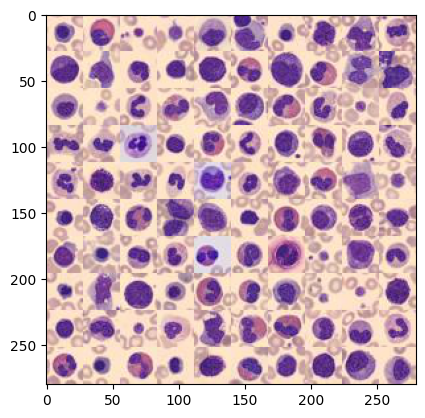

In [12]:
image_grid = train_dataset.montage(length=10) #montage function creates a grid of 10x10 = 100 images from training dataset

import matplotlib.pyplot as plt
plt.imshow(image_grid) #plot grid of images to visualize

In [39]:
#extracts first image [# of channels, height, width] and label from training dataset
img = X_train[1]   # shape is (28, 28, 3)
label = y_train[1] 

print("There are", img.shape[-1], "input input channels for each image. Color images have 3 channels for RGB", "HxW:",img.shape[1:3])
print("The dataset labels are:", train_dataset.info['label'])
print("The train dataset size is:", len(train_dataset))
print("The test dataset size is:", len(test_dataset))

There are 3 input input channels for each image. Color images have 3 channels for RGB HxW: (28, 3)
The dataset labels are: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
The train dataset size is: 11959
The test dataset size is: 3421


In [40]:
label, counts = np.unique(train_dataset.labels, return_counts=True)
#extract the count for each unique label class

pd.DataFrame({
    "Label": label,
    "Count": counts,#number of each unique labels
    "Prevalence (%)": counts / counts.sum() * 100, #prevalence = count of unique label / total counts * 100
})

,Label,Count,Prevalence (%)
0,0,852,7.124342
1,1,2181,18.237311
2,2,1085,9.072665
3,3,2026,16.941216
4,4,849,7.099256
5,5,993,8.303370
6,6,2330,19.483234
7,7,1643,13.738607


### Step 2: Build CNN using TensorFlow/Keras

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(n_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-10 07:13:18.079272: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,352 (880.28 KB)

 Trainable params: 225,352 (880.28 KB)

 Non-trainable params: 0 (0.00 B)

### Step 3: Train and Evaluate

Epoch 1/10


2025-06-10 07:13:28.520074: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 112510272 exceeds 10% of free system memory.


374/374 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.4392 - loss: 1.4824 - val_accuracy: 0.6933 - val_loss: 0.7895
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.6889 - loss: 0.8553 - val_accuracy: 0.7909 - val_loss: 0.5464
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.7460 - loss: 0.6824 - val_accuracy: 0.7681 - val_loss: 0.5453
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.7684 - loss: 0.6378 - val_accuracy: 0.8388 - val_loss: 0.4154
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.7946 - loss: 0.5513 - val_accuracy: 0.8616 - val_loss: 0.3957
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.8102 - loss: 0.5201 - val_accuracy: 0.8657 - val_loss: 0.4125
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.8180 - loss: 0.4950 - val_accuracy: 0.8540 - val_loss: 0.4012
Epoch 8/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.8363 - loss: 0.4767 - val_accuracy

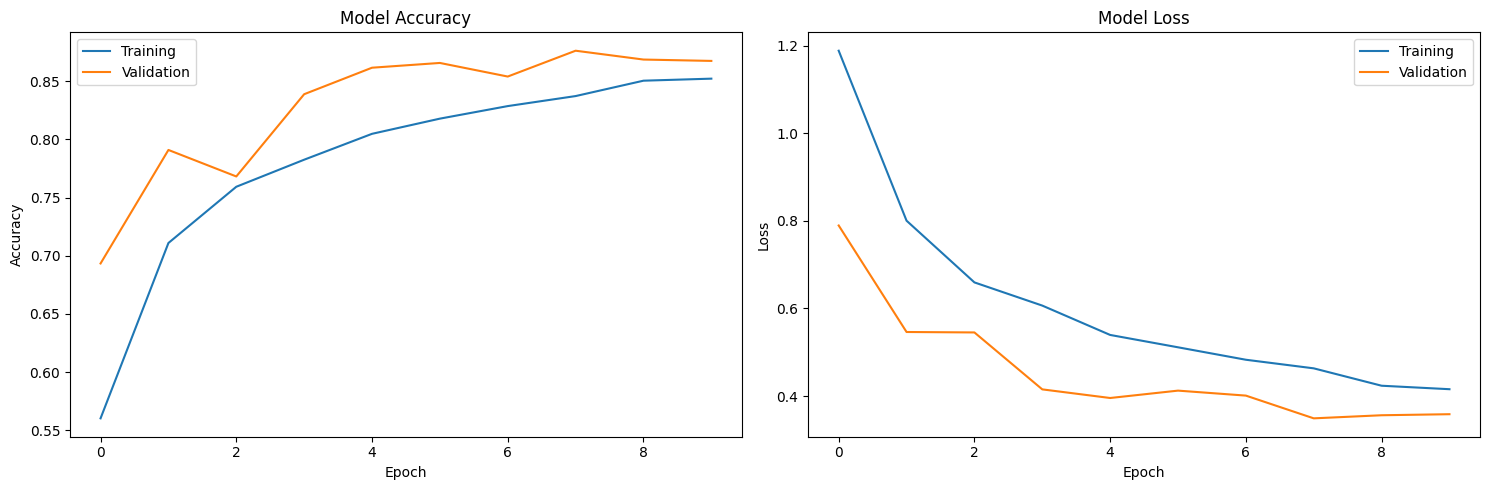

In [42]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'models/cnn_keras.keras',
        save_best_only=True
    )
]

# Train model
history = model.fit(X_train, y_train_cat,
                    validation_data=(X_val, y_val_cat),
                    epochs=10,
                    batch_size=32)


# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Training')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history.history['loss'], label='Training')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

### Step 4: Visualize

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8516 - loss: 0.4504
Test accuracy: 0.8591
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


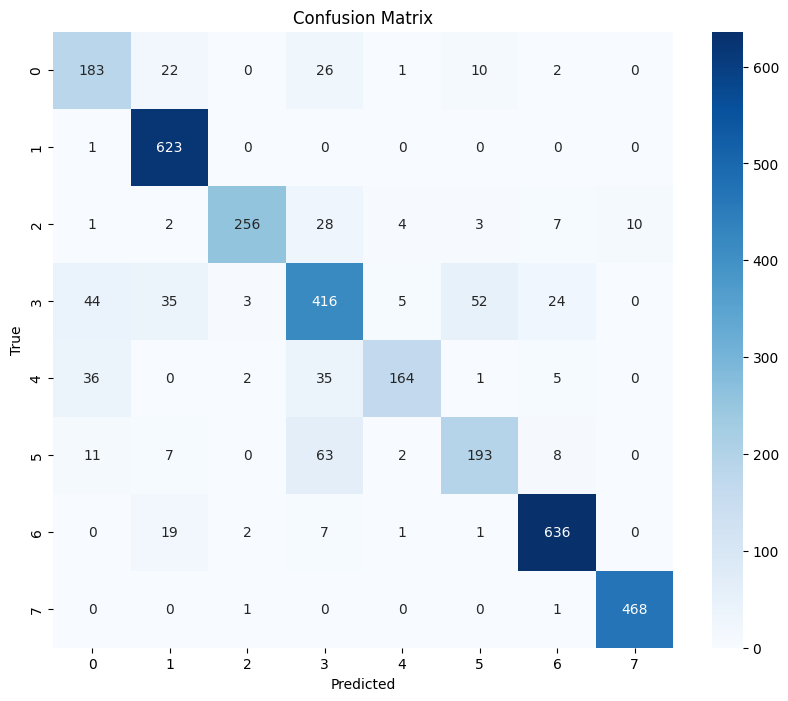

Metrics:
model (bloodmnist_classifier)
accuracy (0.8591055274009705)
precision (0.8616317319580326)
recall (0.85910552470038)
f1_score (0.8573923628425282)
confusion_matrix ([[183, 22, 0, 26, 1, 10, 2, 0], [1, 623, 0, 0, 0, 0, 0, 0], [1, 2, 256, 28, 4, 3, 7, 10], [44, 35, 3, 416, 5, 52, 24, 0], [36, 0, 2, 35, 164, 1, 5, 0], [11, 7, 0, 63, 2, 193, 8, 0], [0, 19, 2, 7, 1, 1, 636, 0], [0, 0, 1, 0, 0, 0, 1, 468]])


In [57]:
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns

# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test accuracy: {test_accuracy:.4f}")

# Get predictions
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test_cat, axis=1)

precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Calculate confusion matrix
cm = tf.math.confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Save metrics
metrics = {
    'model': 'bloodmnist_classifier',
    'accuracy': float(test_accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'confusion_matrix': cm.numpy().tolist()
}

def print_inventory(dct):
    print("Metrics:")
    for item, amount in dct.items(): 
        print("{} ({})".format(item, amount))

print_inventory(metrics)